In [53]:
import torch
import random
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#stock network import
import torchvision.models as models

from torchvision.models import resnet18, ResNet18_Weights
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader

In [54]:
#Setting GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#define model
model = models.resnet18(weights = None)
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout layer
    nn.Linear(num_ftrs, 10)  # Fully connected layer
)

#load trained model
model.load_state_dict(torch.load('/school/intelligence_coursework/Trained_networks/model_state_dict_2.pth'))

#Using GPU
model = model.to(device)
print("Model device:", next(model.parameters()).device)

Model device: cuda:0


In [55]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)), # Random crop back to 32x32
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizing the images
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=4)

classes = trainset.classes
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [56]:
checkpoint = torch.load('/school/intelligence_coursework/Trained_networks/model_clpso_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
particles = checkpoint['particles']
velocities = checkpoint['velocities']
personal_best_positions = checkpoint['personal_best_positions']
personal_best_scores = checkpoint['personal_best_scores']
global_best_position = checkpoint['global_best_position']
global_best_score = checkpoint['global_best_score']
epoch_losses = checkpoint['epoch_losses']
epoch_precisions = checkpoint['epoch_precisions']
model.train()  # Set the model to training mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [57]:
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

#CLPSO
def evaluate(weights):
    with torch.no_grad():
        # Convert numpy arrays to PyTorch tensors
        # Ensure dtype is torch.float32 and tensors are on the correct device
        weights_tensor = torch.tensor(weights, dtype=torch.float32, device=device)
        
        # Split weights into weight and bias for the last layer and reshape
        weight_part = weights_tensor[:-10].view_as(model.fc[1].weight)
        bias_part = weights_tensor[-10:]

        # Check the dtype and convert if necessary
        weight_part = weight_part.to(dtype=torch.float32)
        bias_part = bias_part.to(dtype=torch.float32)

        # Temporarily set the weights of the last layer
        original_weight = model.fc[1].weight.data.clone()
        original_bias = model.fc[1].bias.data.clone()
        
        model.fc[1].weight.data = weight_part
        model.fc[1].bias.data = bias_part

        # Evaluate the model on the validation set
        val_loss = 0.0
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

        # Restore original weights
        model.fc[1].weight.data = original_weight
        model.fc[1].bias.data = original_bias
        return val_loss / len(val_loader.dataset)

In [58]:
#freeze network
for param in model.parameters():
    param.requires_grad = False

    #unfreeze fuly connected layer
for param in model.fc.parameters():
    param.requires_grad = True

#randomize the wights
#model.fc[1].reset_parameters()

# Initialize early stopping
#early_stopping = EarlyStopping(patience=5)

#validation loss
val_loader = DataLoader(testset, batch_size=256, shuffle=True)

# Define CLPSO parameters
num_particles = 100
num_weights = model.fc[1].weight.data.numel() + model.fc[1].bias.data.numel()
#w = 0.6  # Inertia weight
w_begin = 0.9
w_finish = 0.4
bounds = 0.2
c1, c2 = 1.5, 1.5  # Cognitive and social coefficients

# Initialize particles and velocities
#particles = [np.random.uniform(-1, 1, num_weights) for _ in range(num_particles)]
#velocities = [np.zeros(num_weights) for _ in range(num_particles)]
#personal_best_positions = [np.copy(p) for p in particles]
#personal_best_scores = [float('inf') for _ in range(num_particles)]
#global_best_position = None
#global_best_score = float('inf')

global_best_position = np.random.uniform(-1, 1, num_weights)  # Random initialization
global_best_score = float('inf')
    
# List to store average loss per epoch
epoch_losses = []
epoch_precisions = []

fine_tune_epochs = 75
for epoch in range(33, fine_tune_epochs):
    print(f"Starting Epoch {epoch + 1}")
    model.train()  # Set the model to training mode
    # Linearly decrease w
    w = w_begin - (epoch / fine_tune_epochs) * (w_begin - w_finish)
    for i in range(num_particles):
        try:
            # Update velocity and apply bounds
            for d in range(num_weights):
                selected_particle = np.random.choice(num_particles)
                best_position_d = personal_best_positions[selected_particle][d]

                velocities[i][d] = w * velocities[i][d] + c1 * np.random.rand() * (personal_best_positions[i][d] - particles[i][d]) + c2 * np.random.rand() * (best_position_d - particles[i][d])
                velocities[i][d] = np.clip(velocities[i][d], -bounds, bounds)

            # Update particle position
            particles[i] += velocities[i]

            fitness = evaluate(particles[i])
            if fitness < personal_best_scores[i]:
                personal_best_scores[i] = fitness
                personal_best_positions[i] = particles[i].copy()

                # Update model weights with the particle's new position
                with torch.no_grad():
                    particle_tensor = torch.from_numpy(particles[i]).float().to(device)
                    weight_part = particle_tensor[:-10].view_as(model.fc[1].weight)
                    bias_part = particle_tensor[-10:]
                    model.fc[1].weight.data.copy_(weight_part)
                    model.fc[1].bias.data.copy_(bias_part)

            if fitness < global_best_score:
                global_best_score = fitness
                global_best_position = particles[i].copy()
                
            print(f"Epoch {epoch + 1}, Particle {i + 1} updated. Fitness: {fitness:0.4f}")
        except Exception as e:
            print(f"Error in Epoch {epoch}, Particle {i}: {e}")
            break
     # Set model weights to global best after updating all particles
    with torch.no_grad():
        # Ensure the global best position is converted to the correct type and device
        global_best_tensor = torch.from_numpy(global_best_position).float().to(device)
        weight_part = global_best_tensor[:-10].view_as(model.fc[1].weight)
        bias_part = global_best_tensor[-10:]
        model.fc[1].weight.data.copy_(weight_part)
        model.fc[1].bias.data.copy_(bias_part)
    
    # Check data types after assignment
    print("Model weight dtype after update:", model.fc[1].weight.data.dtype)
    print("Model bias dtype after update:", model.fc[1].bias.data.dtype)
    
    # Validation loop + precission
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    all_predict = []
    all_labels = []
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predict = torch.max(outputs, 1)
            all_predict.extend(predict.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    epoch_losses.append(val_loss)
    
    # Calculate and store precision
    precision = precision_score(all_labels, all_predict, average='weighted', zero_division=1)
    epoch_precisions.append(precision)

    print(f"Epoch {epoch + 1} completed. Best score so far: {global_best_score:0.4f}. Validation Loss: {val_loss:0.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Starting Epoch 34
Epoch 34, Particle 1 updated. Fitness: 2.1343
Epoch 34, Particle 2 updated. Fitness: 1.8894
Epoch 34, Particle 3 updated. Fitness: 1.7857
Epoch 34, Particle 4 updated. Fitness: 1.7590
Epoch 34, Particle 5 updated. Fitness: 1.5464
Epoch 34, Particle 6 updated. Fitness: 1.9094
Epoch 34, Particle 7 updated. Fitness: 1.9217
Epoch 34, Particle 8 updated. Fitness: 1.7236
Epoch 34, Particle 9 updated. Fitness: 2.0470
Epoch 34, Particle 10 updated. Fitness: 1.9643
Epoch 34, Particle 11 updated. Fitness: 1.6406
Epoch 34, Particle 12 updated. Fitness: 2.0557
Epoch 34, Particle 13 updated. Fitness: 1.8650
Epoch 34, Particle 14 updated. Fitness: 1.8574
Epoch 34, Particle 15 updated. Fitness: 1.8298
Epoch 34, Particle 16 updated. Fitness: 1.6963
Epoch 34, Particle 17 updated. Fitness: 1.7569
Epoch 34, Particle 18 updated. Fitness: 1.8391
Epoch 34, Particle 19 updated. Fitness: 1.6343
Epoch 34, Particle 20 updated. Fitness: 2.1122
Epoch 34, Particle 21 updated. Fitness: 1.9876
Epoc

Epoch 35, Particle 72 updated. Fitness: 1.8334
Epoch 35, Particle 73 updated. Fitness: 2.0795
Epoch 35, Particle 74 updated. Fitness: 2.1289
Epoch 35, Particle 75 updated. Fitness: 1.8851
Epoch 35, Particle 76 updated. Fitness: 1.6341
Epoch 35, Particle 77 updated. Fitness: 1.9207
Epoch 35, Particle 78 updated. Fitness: 2.2956
Epoch 35, Particle 79 updated. Fitness: 1.8689
Epoch 35, Particle 80 updated. Fitness: 1.5672
Epoch 35, Particle 81 updated. Fitness: 2.1246
Epoch 35, Particle 82 updated. Fitness: 1.6917
Epoch 35, Particle 83 updated. Fitness: 2.0265
Epoch 35, Particle 84 updated. Fitness: 1.8058
Epoch 35, Particle 85 updated. Fitness: 1.5353
Epoch 35, Particle 86 updated. Fitness: 1.5872
Epoch 35, Particle 87 updated. Fitness: 1.8758
Epoch 35, Particle 88 updated. Fitness: 2.0152
Epoch 35, Particle 89 updated. Fitness: 1.6046
Epoch 35, Particle 90 updated. Fitness: 2.1722
Epoch 35, Particle 91 updated. Fitness: 1.7208
Epoch 35, Particle 92 updated. Fitness: 1.9554
Epoch 35, Par

Epoch 37, Particle 39 updated. Fitness: 1.7602
Epoch 37, Particle 40 updated. Fitness: 1.4597
Epoch 37, Particle 41 updated. Fitness: 1.6372
Epoch 37, Particle 42 updated. Fitness: 1.9715
Epoch 37, Particle 43 updated. Fitness: 1.5496
Epoch 37, Particle 44 updated. Fitness: 2.0722
Epoch 37, Particle 45 updated. Fitness: 1.7903
Epoch 37, Particle 46 updated. Fitness: 1.6339
Epoch 37, Particle 47 updated. Fitness: 1.7270
Epoch 37, Particle 48 updated. Fitness: 1.6999
Epoch 37, Particle 49 updated. Fitness: 1.7341
Epoch 37, Particle 50 updated. Fitness: 2.0776
Epoch 37, Particle 51 updated. Fitness: 1.8158
Epoch 37, Particle 52 updated. Fitness: 2.0298
Epoch 37, Particle 53 updated. Fitness: 2.0145
Epoch 37, Particle 54 updated. Fitness: 1.7484
Epoch 37, Particle 55 updated. Fitness: 1.9351
Epoch 37, Particle 56 updated. Fitness: 1.6971
Epoch 37, Particle 57 updated. Fitness: 2.0592
Epoch 37, Particle 58 updated. Fitness: 1.5522
Epoch 37, Particle 59 updated. Fitness: 1.9148
Epoch 37, Par

Epoch 39, Particle 6 updated. Fitness: 1.7277
Epoch 39, Particle 7 updated. Fitness: 1.5686
Epoch 39, Particle 8 updated. Fitness: 1.7082
Epoch 39, Particle 9 updated. Fitness: 1.8696
Epoch 39, Particle 10 updated. Fitness: 1.8293
Epoch 39, Particle 11 updated. Fitness: 1.6632
Epoch 39, Particle 12 updated. Fitness: 1.8698
Epoch 39, Particle 13 updated. Fitness: 1.8789
Epoch 39, Particle 14 updated. Fitness: 1.8187
Epoch 39, Particle 15 updated. Fitness: 1.7689
Epoch 39, Particle 16 updated. Fitness: 1.7781
Epoch 39, Particle 17 updated. Fitness: 1.7894
Epoch 39, Particle 18 updated. Fitness: 1.8393
Epoch 39, Particle 19 updated. Fitness: 1.6006
Epoch 39, Particle 20 updated. Fitness: 1.7851
Epoch 39, Particle 21 updated. Fitness: 1.6570
Epoch 39, Particle 22 updated. Fitness: 1.6764
Epoch 39, Particle 23 updated. Fitness: 1.6507
Epoch 39, Particle 24 updated. Fitness: 1.6319
Epoch 39, Particle 25 updated. Fitness: 1.5448
Epoch 39, Particle 26 updated. Fitness: 1.7448
Epoch 39, Particl

Epoch 40, Particle 77 updated. Fitness: 1.8456
Epoch 40, Particle 78 updated. Fitness: 1.5298
Epoch 40, Particle 79 updated. Fitness: 1.6254
Epoch 40, Particle 80 updated. Fitness: 1.5150
Epoch 40, Particle 81 updated. Fitness: 1.5162
Epoch 40, Particle 82 updated. Fitness: 1.9214
Epoch 40, Particle 83 updated. Fitness: 1.8989
Epoch 40, Particle 84 updated. Fitness: 1.5910
Epoch 40, Particle 85 updated. Fitness: 1.5349
Epoch 40, Particle 86 updated. Fitness: 1.5395
Epoch 40, Particle 87 updated. Fitness: 1.9908
Epoch 40, Particle 88 updated. Fitness: 1.6545
Epoch 40, Particle 89 updated. Fitness: 1.8483
Epoch 40, Particle 90 updated. Fitness: 1.4421
Epoch 40, Particle 91 updated. Fitness: 1.6776
Epoch 40, Particle 92 updated. Fitness: 1.9853
Epoch 40, Particle 93 updated. Fitness: 1.9708
Epoch 40, Particle 94 updated. Fitness: 1.7772
Epoch 40, Particle 95 updated. Fitness: 1.8091
Epoch 40, Particle 96 updated. Fitness: 1.6674
Epoch 40, Particle 97 updated. Fitness: 1.6710
Epoch 40, Par

Epoch 42, Particle 44 updated. Fitness: 1.8055
Epoch 42, Particle 45 updated. Fitness: 1.6619
Epoch 42, Particle 46 updated. Fitness: 1.6543
Epoch 42, Particle 47 updated. Fitness: 1.9811
Epoch 42, Particle 48 updated. Fitness: 1.8388
Epoch 42, Particle 49 updated. Fitness: 1.8944
Epoch 42, Particle 50 updated. Fitness: 1.4802
Epoch 42, Particle 51 updated. Fitness: 1.7305
Epoch 42, Particle 52 updated. Fitness: 1.5202
Epoch 42, Particle 53 updated. Fitness: 1.7623
Epoch 42, Particle 54 updated. Fitness: 1.6033
Epoch 42, Particle 55 updated. Fitness: 1.4445
Epoch 42, Particle 56 updated. Fitness: 1.5798
Epoch 42, Particle 57 updated. Fitness: 1.8201
Epoch 42, Particle 58 updated. Fitness: 1.6710
Epoch 42, Particle 59 updated. Fitness: 1.6827
Epoch 42, Particle 60 updated. Fitness: 1.5860
Epoch 42, Particle 61 updated. Fitness: 1.6660
Epoch 42, Particle 62 updated. Fitness: 1.9517
Epoch 42, Particle 63 updated. Fitness: 1.6975
Epoch 42, Particle 64 updated. Fitness: 1.4301
Epoch 42, Par

Epoch 44, Particle 11 updated. Fitness: 1.6323
Epoch 44, Particle 12 updated. Fitness: 1.4048
Epoch 44, Particle 13 updated. Fitness: 1.7094
Epoch 44, Particle 14 updated. Fitness: 1.5576
Epoch 44, Particle 15 updated. Fitness: 1.5125
Epoch 44, Particle 16 updated. Fitness: 1.6009
Epoch 44, Particle 17 updated. Fitness: 1.5832
Epoch 44, Particle 18 updated. Fitness: 1.6024
Epoch 44, Particle 19 updated. Fitness: 1.5640
Epoch 44, Particle 20 updated. Fitness: 1.6773
Epoch 44, Particle 21 updated. Fitness: 1.6137
Epoch 44, Particle 22 updated. Fitness: 1.6703
Epoch 44, Particle 23 updated. Fitness: 1.7772
Epoch 44, Particle 24 updated. Fitness: 1.5528
Epoch 44, Particle 25 updated. Fitness: 1.5616
Epoch 44, Particle 26 updated. Fitness: 1.6697
Epoch 44, Particle 27 updated. Fitness: 1.6006
Epoch 44, Particle 28 updated. Fitness: 1.5720
Epoch 44, Particle 29 updated. Fitness: 1.6252
Epoch 44, Particle 30 updated. Fitness: 1.5784
Epoch 44, Particle 31 updated. Fitness: 1.7759
Epoch 44, Par

Epoch 45, Particle 82 updated. Fitness: 1.6386
Epoch 45, Particle 83 updated. Fitness: 1.7573
Epoch 45, Particle 84 updated. Fitness: 1.4962
Epoch 45, Particle 85 updated. Fitness: 1.5301
Epoch 45, Particle 86 updated. Fitness: 1.6414
Epoch 45, Particle 87 updated. Fitness: 1.4829
Epoch 45, Particle 88 updated. Fitness: 1.3127
Epoch 45, Particle 89 updated. Fitness: 1.7130
Epoch 45, Particle 90 updated. Fitness: 1.4078
Epoch 45, Particle 91 updated. Fitness: 1.6183
Epoch 45, Particle 92 updated. Fitness: 1.4078
Epoch 45, Particle 93 updated. Fitness: 1.5966
Epoch 45, Particle 94 updated. Fitness: 1.6433
Epoch 45, Particle 95 updated. Fitness: 1.7586
Epoch 45, Particle 96 updated. Fitness: 1.6584
Epoch 45, Particle 97 updated. Fitness: 1.7456
Epoch 45, Particle 98 updated. Fitness: 1.5376
Epoch 45, Particle 99 updated. Fitness: 1.8156
Epoch 45, Particle 100 updated. Fitness: 1.6858
Model weight dtype after update: torch.float32
Model bias dtype after update: torch.float32
Epoch 45 compl

Epoch 47, Particle 49 updated. Fitness: 1.4806
Epoch 47, Particle 50 updated. Fitness: 1.8024
Epoch 47, Particle 51 updated. Fitness: 1.3975
Epoch 47, Particle 52 updated. Fitness: 1.4213
Epoch 47, Particle 53 updated. Fitness: 1.2995
Epoch 47, Particle 54 updated. Fitness: 1.4785
Epoch 47, Particle 55 updated. Fitness: 1.6212
Epoch 47, Particle 56 updated. Fitness: 1.4012
Epoch 47, Particle 57 updated. Fitness: 1.6700
Epoch 47, Particle 58 updated. Fitness: 1.5478
Epoch 47, Particle 59 updated. Fitness: 1.5488
Epoch 47, Particle 60 updated. Fitness: 1.5252
Epoch 47, Particle 61 updated. Fitness: 1.5362
Epoch 47, Particle 62 updated. Fitness: 1.8344
Epoch 47, Particle 63 updated. Fitness: 1.5420
Epoch 47, Particle 64 updated. Fitness: 1.3562
Epoch 47, Particle 65 updated. Fitness: 1.4307
Epoch 47, Particle 66 updated. Fitness: 1.3206
Epoch 47, Particle 67 updated. Fitness: 1.3111
Epoch 47, Particle 68 updated. Fitness: 1.7429
Epoch 47, Particle 69 updated. Fitness: 1.4962
Epoch 47, Par

Epoch 49, Particle 16 updated. Fitness: 1.4817
Epoch 49, Particle 17 updated. Fitness: 1.7110
Epoch 49, Particle 18 updated. Fitness: 1.6851
Epoch 49, Particle 19 updated. Fitness: 1.3740
Epoch 49, Particle 20 updated. Fitness: 1.6646
Epoch 49, Particle 21 updated. Fitness: 1.6053
Epoch 49, Particle 22 updated. Fitness: 1.7802
Epoch 49, Particle 23 updated. Fitness: 1.4904
Epoch 49, Particle 24 updated. Fitness: 1.6022
Epoch 49, Particle 25 updated. Fitness: 1.6177
Epoch 49, Particle 26 updated. Fitness: 1.4687
Epoch 49, Particle 27 updated. Fitness: 1.3401
Epoch 49, Particle 28 updated. Fitness: 1.4334
Epoch 49, Particle 29 updated. Fitness: 1.6588
Epoch 49, Particle 30 updated. Fitness: 1.6018
Epoch 49, Particle 31 updated. Fitness: 1.4493
Epoch 49, Particle 32 updated. Fitness: 1.6501
Epoch 49, Particle 33 updated. Fitness: 1.5769
Epoch 49, Particle 34 updated. Fitness: 1.6330
Epoch 49, Particle 35 updated. Fitness: 1.6384
Epoch 49, Particle 36 updated. Fitness: 1.4453
Epoch 49, Par

Epoch 50, Particle 87 updated. Fitness: 1.5508
Epoch 50, Particle 88 updated. Fitness: 1.6087
Epoch 50, Particle 89 updated. Fitness: 1.4255
Epoch 50, Particle 90 updated. Fitness: 1.5725
Epoch 50, Particle 91 updated. Fitness: 1.3143
Epoch 50, Particle 92 updated. Fitness: 1.4178
Epoch 50, Particle 93 updated. Fitness: 1.3319
Epoch 50, Particle 94 updated. Fitness: 1.5213
Epoch 50, Particle 95 updated. Fitness: 1.5613
Epoch 50, Particle 96 updated. Fitness: 1.8037
Epoch 50, Particle 97 updated. Fitness: 1.4964
Epoch 50, Particle 98 updated. Fitness: 1.6226
Epoch 50, Particle 99 updated. Fitness: 1.3370
Epoch 50, Particle 100 updated. Fitness: 1.5246
Model weight dtype after update: torch.float32
Model bias dtype after update: torch.float32
Epoch 50 completed. Best score so far: 1.2421. Validation Loss: 0.8156
Starting Epoch 51
Epoch 51, Particle 1 updated. Fitness: 1.4825
Epoch 51, Particle 2 updated. Fitness: 1.3093
Epoch 51, Particle 3 updated. Fitness: 1.6334
Epoch 51, Particle 4 u

In [49]:
torch.save({
    'model_state_dict': model.state_dict(),
    'particles': particles,
    'velocities': velocities,
    'personal_best_positions': personal_best_positions,
    'personal_best_scores': personal_best_scores,
    'global_best_position': global_best_position,
    'global_best_score': global_best_score,
    'epoch_losses': epoch_losses,
    'epoch_precisions': epoch_precisions
}, '/school/intelligence_coursework/Trained_networks/model_clpso_checkpoint.pth')

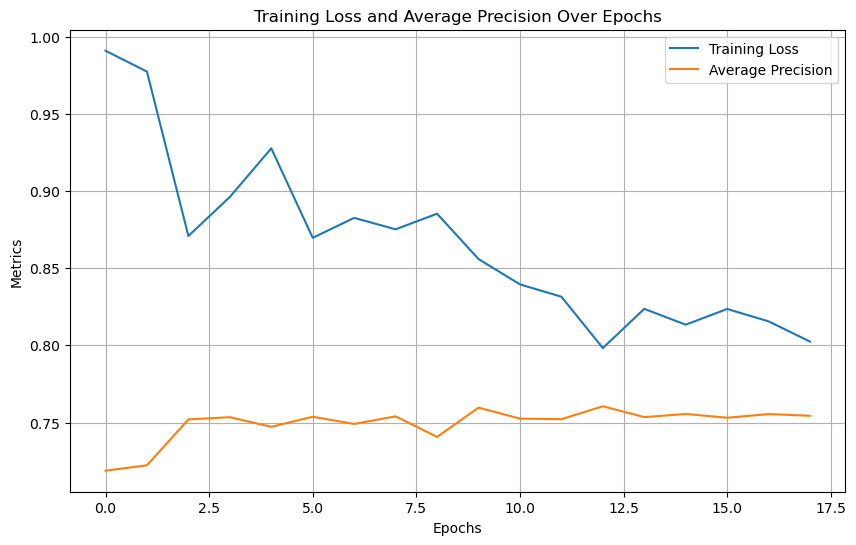

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss')
plt.plot(epoch_precisions, label='Average Precision')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Training Loss and Average Precision Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label.item()]] += 1
            total_pred[classes[label.item()]] += 1
            
print('Accuracy of the network on the 10 000 test images: %f %%' % (100 * correct / total))

for classname, correct_count in correct_pred.items():
    accuracy = 100* float(correct_count)/ total_pred[classname]
    print(f'Accuracy for: {classname:5s} is {accuracy:0.1f} %')

Accuracy of the network on the 10 000 test images: 74.820000 %
Accuracy for: airplane is 65.9 %
Accuracy for: automobile is 90.7 %
Accuracy for: bird  is 56.7 %
Accuracy for: cat   is 46.0 %
Accuracy for: deer  is 84.7 %
Accuracy for: dog   is 64.9 %
Accuracy for: frog  is 91.5 %
Accuracy for: horse is 75.5 %
Accuracy for: ship  is 89.3 %
Accuracy for: truck is 83.0 %


Precision: 0.4339
Recall: 0.4420
F1 Score: 0.4230


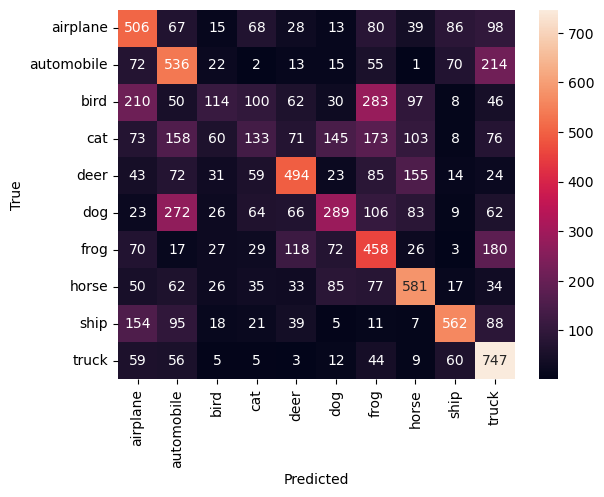

In [52]:
all_labels = []
all_predictions = []

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

# Concatenate all batches
all_labels = np.concatenate(all_labels)
all_predictions = np.concatenate(all_predictions)

#Assigning classes
def indices_to_class_names(indices, class_names):
    return [class_names[i] for i in indices]

# Apply the mapping to all labels and predictions
all_labels_names = indices_to_class_names(all_labels, classes)
all_predictions_names = indices_to_class_names(all_predictions, classes)

# Calculate metrics using the numerical indices
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

# Print metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix with Class Names
conf_matrix = confusion_matrix(all_labels_names, all_predictions_names)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()